In [14]:
#%pip install numpy pandas matplotlib scikit-learn tensorflow seaborn folium xgboost

In [15]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
df1 = pd.read_csv("../../data/dev101_resample10T.csv")
df2 = pd.read_csv("../../data/dev102_resample10T.csv")

df_all = pd.concat([df1, df2], ignore_index=True)
#df_all = pd.read_csv("../../data/devAll2_prepared.csv")

# แปลง timestamp และเรียงลำดับ
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_all = df_all.sort_values(by='timestamp').reset_index(drop=True)
df_all

,timestamp,soil_mean,soil_std,soil_min,soil_max,rain_mean,rain_std,rain_min,rain_max,temp_mean,...,geo_max,lat_mean,lat_std,lat_min,lat_max,lng_mean,lng_std,lng_min,lng_max,devID
0,2025-05-02 11:40:00,28.807142,0.026066,28.799999,28.900000,0.0,0.0,0.0,0.0,34.483864,...,19.812029,8.637995,1.550673e-06,8.637993,8.637999,99.899005,0.000004,99.899002,99.899010,101
1,2025-05-02 11:40:00,22.200001,0.000000,22.200001,22.200001,0.0,0.0,0.0,0.0,34.717920,...,19.277988,8.637967,2.491500e-06,8.637963,8.637971,99.898938,0.000004,99.898933,99.898941,102
2,2025-05-02 11:50:00,22.203572,0.018725,22.200001,22.299999,0.0,0.0,0.0,0.0,34.847077,...,32.031639,8.637968,1.779165e-06,8.637963,8.637971,99.898930,0.000004,99.898926,99.898941,102
3,2025-05-02 11:50:00,28.796363,0.018892,28.700001,28.799999,0.0,0.0,0.0,0.0,34.705092,...,19.805017,8.637991,2.022327e-06,8.637987,8.637995,99.899003,0.000002,99.899002,99.899010,101
4,2025-05-02 12:00:00,28.757143,0.049934,28.700001,28.799999,0.0,0.0,0.0,0.0,35.428349,...,19.796062,8.637991,2.108593e-06,8.637988,8.637995,99.899009,0.000002,99.899002,99.899010,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6516,2025-06-29 20:00:00,27.913043,0.034435,27.900000,28.000000,0.0,0.0,0.0,0.0,29.834574,...,31.988052,8.638007,3.455662e-06,8.638004,8.638018,99.898987,0.000000,99.898987,99.898987,101
6517,2025-06-29 20:10:00,27.900000,0.000000,27.900000,27.900000,0.0,0.0,0.0,0.0,29.834822,...,31.985922,8.638013,2.712515e-06,8.638008,8.638016,99.898981,0.000007,99.898972,99.898987,101
6518,2025-06-29 20:10:00,25.600000,0.000000,25.600000,25.600000,0.0,0.0,0.0,0.0,29.742026,...,19.789551,8.637934,3.948066e-06,8.637927,8.637938,99.898950,0.000005,99.898941,99.898956,102
6519,2025-06-29 20:20:00,27.900000,0.000000,27.900000,27.900000,0.0,0.0,0.0,0.0,29.572938,...,9.696708,8.638011,3.894689e-07,8.638010,8.638011,99.898972,0.000000,99.898972,99.898972,101


In [17]:
print(df_all['devID'].value_counts())

devID
102    3336
101    3185
Name: count, dtype: int64


In [18]:
print(df_all.columns)

Index(['timestamp', 'soil_mean', 'soil_std', 'soil_min', 'soil_max',
       'rain_mean', 'rain_std', 'rain_min', 'rain_max', 'temp_mean',
       'temp_std', 'temp_min', 'temp_max', 'humi_mean', 'humi_std', 'humi_min',
       'humi_max', 'geo_mean', 'geo_std', 'geo_min', 'geo_max', 'lat_mean',
       'lat_std', 'lat_min', 'lat_max', 'lng_mean', 'lng_std', 'lng_min',
       'lng_max', 'devID'],
      dtype='object')


In [19]:
# Feature ที่จะใช้
numerical_cols =  [
    'soil_mean', 'soil_std', 'rain_mean', 'rain_std',
    'temp_mean', 'temp_std', 'humi_mean', 'humi_std',
    'geo_mean', 'lat_mean', 'lng_mean',
    'soil_min', 'soil_max', 'rain_min', 'rain_max',
    'temp_min', 'temp_max', 'humi_min', 'humi_max'
]

# สร้าง Scaler และฟิตข้อมูล
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_all[numerical_cols])

# เพิ่มคอลัมน์ scaled กลับเข้า DataFrame
for i, col in enumerate(numerical_cols):
    df_all[f'scaled_{col}'] = scaled_values[:, i]

# Save scaler (สำหรับใช้งานจริงในอนาคต)
joblib.dump(scaler, 'scaler4.save')


['scaler4.save']

In [20]:
SEQUENCE_LENGTH = 72

def create_sequences_by_device(df, sequence_length, numerical_cols, dev_ids=None, return_index=False):
    """
    สร้าง sequence สำหรับแต่ละ device (devID)
    Args:
        df: DataFrame ที่เตรียมข้อมูลแล้ว
        sequence_length: ความยาว sequence
        numerical_cols: รายชื่อคอลัมน์ feature
        dev_ids: รายชื่อ devID ที่ต้องการ (None = ทุก devID)
        return_index: คืนค่า original index ของแถวสุดท้ายในแต่ละ sequence หรือไม่
    Returns:
        sequences: np.array (num_seq, seq_len, num_feat)
        device_ids: รายชื่อ devID ของแต่ละ sequence
        timestamps: timestamp สุดท้ายของแต่ละ sequence
        (option) last_indices: index ของแถวสุดท้ายในแต่ละ sequence (ใน df)
    """
    sequences = []
    device_ids = []
    timestamps = []
    last_indices = []
    groupby_obj = df.groupby('devID')
    for dev_id, group in groupby_obj:
        if dev_ids is not None and dev_id not in dev_ids:
            continue
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        time_vals = group['timestamp'].values
        idx_vals = group.index.values
        for i in range(len(values) - sequence_length + 1):
            sequences.append(values[i:i + sequence_length])
            device_ids.append(dev_id)
            timestamps.append(time_vals[i + sequence_length - 1])
            if return_index:
                last_indices.append(idx_vals[i + sequence_length - 1])
    if return_index:
        return np.array(sequences), device_ids, timestamps, last_indices
    else:
        return np.array(sequences), device_ids, timestamps

# ตัวอย่างการใช้งานปกติ
X_seq, device_ids, seq_timestamps = create_sequences_by_device(df_all, SEQUENCE_LENGTH, numerical_cols)



In [21]:
n = len(X_seq)
train_size = int(n * 0.9)
val_size = int(n * 0.1)

X_train = X_seq[:train_size]
X_val = X_seq[train_size:train_size + val_size]

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (5741, 72, 19), Val: (637, 72, 19)


In [22]:
n_features = len(numerical_cols)
input_shape = (SEQUENCE_LENGTH, n_features)

# Encoder
inputs = Input(shape=input_shape) 
x = LSTM(128, return_sequences=True)(inputs)  # Layer 1
x = LSTM(64, return_sequences=False)(x)        # Layer 2

# Bridge
x = RepeatVector(SEQUENCE_LENGTH)(x)           # Layer 3

# Decoder
x = LSTM(64, return_sequences=True)(x)         # Layer 4
x = LSTM(128, return_sequences=True)(x)        # Layer 5

# Output Layer
outputs = TimeDistributed(Dense(n_features))(x)  # Layer 6

# Model
model = Model(inputs, outputs)
model.compile(optimizer=Adam(0.001), loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 72, 19)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 72, 128)        │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 72, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 72, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 72, 19)         │         2,451 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,475 (1013.57 KB)

 Trainable params: 259,475 (1013.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 0.0498 - val_loss: 0.0163
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 0.0123 - val_loss: 0.0070
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - loss: 0.0036 - val_loss: 0.0042
Restoring model weights from the end of the best epoch: 9.


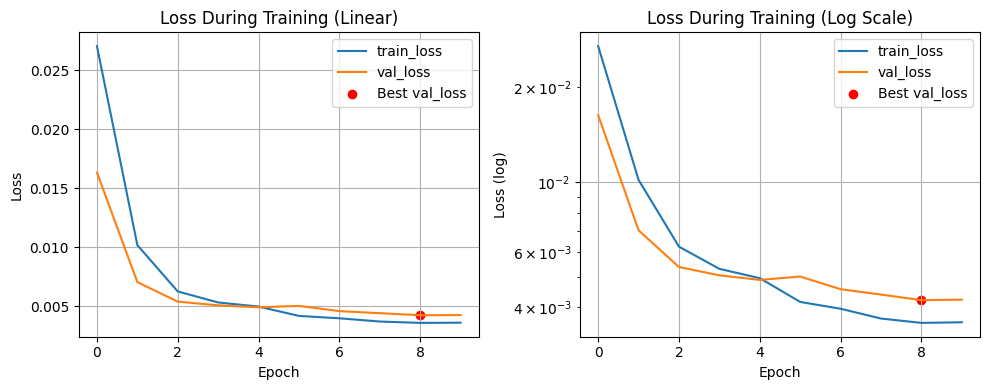

Best epoch: 9, Best val_loss: 0.004218
Loss history saved to train_loss_history.csv


In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=10, #90
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save model
model.save('lstm_autoencoder_model4.h5')

# Save loss history to CSV
import pandas as pd
loss_df = pd.DataFrame(history.history)
loss_df.to_csv('train_loss_history.csv', index=False)

# Plot loss (linear and log scale)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss During Training (Linear)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.title('Loss During Training (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.grid(True)

# Mark best epoch
best_epoch = int(np.argmin(history.history['val_loss']))
plt.subplot(1, 2, 1)
plt.scatter(best_epoch, history.history['val_loss'][best_epoch], color='red', label='Best val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(best_epoch, history.history['val_loss'][best_epoch], color='red', label='Best val_loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best epoch: {best_epoch+1}, Best val_loss: {history.history['val_loss'][best_epoch]:.6f}")
print("Loss history saved to train_loss_history.csv")


# Test

In [59]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA

df1 = pd.read_csv("../../data/dev101_resample10T.csv")
df2 = pd.read_csv("../../data/dev102_resample10T.csv")

df_test = pd.concat([df1, df2], ignore_index=True)
#df_all = pd.read_csv("../../data/devAll2_prepared.csv")

# แปลง timestamp และเรียงลำดับ
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test.sort_values(by='timestamp').reset_index(drop=True)
df_test

,timestamp,soil_mean,soil_std,soil_min,soil_max,rain_mean,rain_std,rain_min,rain_max,temp_mean,...,geo_max,lat_mean,lat_std,lat_min,lat_max,lng_mean,lng_std,lng_min,lng_max,devID
0,2025-05-02 11:40:00,28.807142,0.026066,28.799999,28.900000,0.0,0.0,0.0,0.0,34.483864,...,19.812029,8.637995,1.550673e-06,8.637993,8.637999,99.899005,0.000004,99.899002,99.899010,101
1,2025-05-02 11:40:00,22.200001,0.000000,22.200001,22.200001,0.0,0.0,0.0,0.0,34.717920,...,19.277988,8.637967,2.491500e-06,8.637963,8.637971,99.898938,0.000004,99.898933,99.898941,102
2,2025-05-02 11:50:00,22.203572,0.018725,22.200001,22.299999,0.0,0.0,0.0,0.0,34.847077,...,32.031639,8.637968,1.779165e-06,8.637963,8.637971,99.898930,0.000004,99.898926,99.898941,102
3,2025-05-02 11:50:00,28.796363,0.018892,28.700001,28.799999,0.0,0.0,0.0,0.0,34.705092,...,19.805017,8.637991,2.022327e-06,8.637987,8.637995,99.899003,0.000002,99.899002,99.899010,101
4,2025-05-02 12:00:00,28.757143,0.049934,28.700001,28.799999,0.0,0.0,0.0,0.0,35.428349,...,19.796062,8.637991,2.108593e-06,8.637988,8.637995,99.899009,0.000002,99.899002,99.899010,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6516,2025-06-29 20:00:00,27.913043,0.034435,27.900000,28.000000,0.0,0.0,0.0,0.0,29.834574,...,31.988052,8.638007,3.455662e-06,8.638004,8.638018,99.898987,0.000000,99.898987,99.898987,101
6517,2025-06-29 20:10:00,27.900000,0.000000,27.900000,27.900000,0.0,0.0,0.0,0.0,29.834822,...,31.985922,8.638013,2.712515e-06,8.638008,8.638016,99.898981,0.000007,99.898972,99.898987,101
6518,2025-06-29 20:10:00,25.600000,0.000000,25.600000,25.600000,0.0,0.0,0.0,0.0,29.742026,...,19.789551,8.637934,3.948066e-06,8.637927,8.637938,99.898950,0.000005,99.898941,99.898956,102
6519,2025-06-29 20:20:00,27.900000,0.000000,27.900000,27.900000,0.0,0.0,0.0,0.0,29.572938,...,9.696708,8.638011,3.894689e-07,8.638010,8.638011,99.898972,0.000000,99.898972,99.898972,101


In [60]:

#df_test = df_test[df_test['devID'] == 102]  # devID เป็น int ใน df_test
df_original_features = df_test.copy()

df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test.sort_values(by='timestamp').reset_index(drop=True)

scaler = joblib.load('scaler4.save')
numerical_cols = ['soil_mean', 'soil_std', 'rain_mean', 'rain_std',
    'temp_mean', 'temp_std', 'humi_mean', 'humi_std',
    'geo_mean', 'lat_mean', 'lng_mean',
    'soil_min', 'soil_max', 'rain_min', 'rain_max',
    'temp_min', 'temp_max', 'humi_min', 'humi_max'
]

missing_cols = [col for col in numerical_cols if col not in df_test.columns]
if missing_cols:
    raise ValueError(f"Missing columns in input CSV: {missing_cols}")

# โหลด MinMaxScaler ที่เทรนไว้
scaled_values = scaler.transform(df_test[numerical_cols])
for i, col in enumerate(numerical_cols):
    df_test[f'scaled_{col}'] = scaled_values[:, i]

# === sequence for predict ===
SEQUENCE_LENGTH = 72

def create_sequences(df, sequence_length, numerical_cols):
    sequences, device_ids, timestamps = [], [], []
    # เก็บ index เริ่มต้นของแต่ละ sequence เพื่อเชื่อมโยงกับ df_test
    start_indices = []

    for dev_id, group in df.groupby('devID'):
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        time_vals = group['timestamp'].values
        
        # เพิ่มคอลัมน์ original_index เพื่อให้สามารถเชื่อมโยงกลับไปยัง df_test ได้
        group = group.reset_index(drop=False).rename(columns={'index': 'original_df_index'})

        for i in range(len(values) - sequence_length + 1):
            sequences.append(values[i:i + sequence_length])
            device_ids.append(dev_id)
            timestamps.append(time_vals[i + sequence_length - 1]) # timestamp ของจุดสุดท้ายใน sequence
            start_indices.append(group['original_df_index'].iloc[i + sequence_length - 1]) # เก็บ original index ของจุดสุดท้าย

    return np.array(sequences), device_ids, timestamps, start_indices

# สร้าง sequence
X_seq_test, device_ids_test, timestamps_test, start_indices_test = create_sequences(df_test, SEQUENCE_LENGTH, numerical_cols)

# === 5. โหลดโมเดลและ predict ===
model = load_model('lstm_autoencoder_model4.h5', compile=False)
X_pred = model.predict(X_seq_test)

# === 6. คำนวณ reconstruction error ===
reconstruction_error = np.mean(np.mean(np.square(X_seq_test - X_pred), axis=1), axis=1)

# === 7. สร้าง DataFrame เก็บผล ===
df_results = pd.DataFrame({
    'devID': device_ids_test,
    'timestamp': timestamps_test,
    'reconstruction_error': reconstruction_error,
    'original_df_index': start_indices_test # เพิ่มคอลัมน์นี้เพื่อ merge กับ df_original_features
})


200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step


In [ ]:

# === 8. คำนวณ thresholds และกำหนด Anomaly Level ===
threshold_warning = 0.008
threshold_critical = np.percentile(reconstruction_error, 99)
#threshold_warning = 0.00758 95%
#threshold_critical = 0.01009 99%

def classify_anomaly(err):
    if err > threshold_critical:
        return 'critical'
    elif err > threshold_warning:
        return 'warning'
    else:
        return 'normal'

df_results['anomaly_level'] = df_results['reconstruction_error'].apply(classify_anomaly)

print(f"95th percentile (Warning) threshold = {threshold_warning:.5f}")
print(f"99th percentile (Critical) threshold = {threshold_critical:.5f}")
print("\n--- Anomaly Level Counts ---")
print(df_results['anomaly_level'].value_counts())

95th percentile (Warning) threshold = 0.00800
99th percentile (Critical) threshold = 0.01009

--- Anomaly Level Counts ---
anomaly_level
normal      6112
warning      203
critical      64
Name: count, dtype: int64


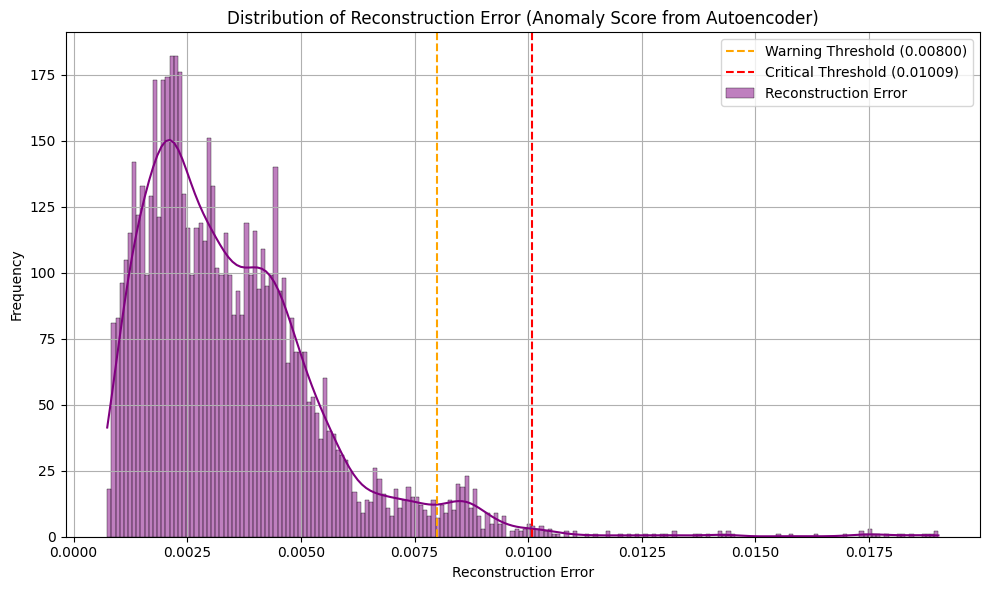

In [62]:
# --- การรวมข้อมูลเพื่อการวิเคราะห์เพิ่มเติม ---

df_original_features = df_original_features.loc[:, ~df_original_features.columns.duplicated()]

if 'original_df_index' not in df_original_features.columns:
    df_original_features = df_original_features.reset_index().rename(columns={'index': 'original_df_index'})

df_original_features['timestamp'] = pd.to_datetime(df_original_features['timestamp'])

# Merge ข้อมูล
df_analysis = pd.merge(df_results, df_original_features, on=['devID', 'timestamp', 'original_df_index'], how='left')

if df_analysis.isnull().any().any():
    print("\nWarning: Missing values found in merged DataFrame. Ensure timestamps and devIDs match for accurate feature analysis.")

palette_anomaly = {'normal': 'green', 'warning': 'orange', 'critical': 'red'}

# --- 1. Distribution of Reconstruction Error ---
plt.figure(figsize=(10, 6))
sns.histplot(df_results['reconstruction_error'], bins=200, kde=True, color='purple', label='Reconstruction Error')
plt.axvline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axvline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Distribution of Reconstruction Error (Anomaly Score from Autoencoder)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\ahmad\AppData\Local\Temp\ipykernel_6736\4259196113.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)


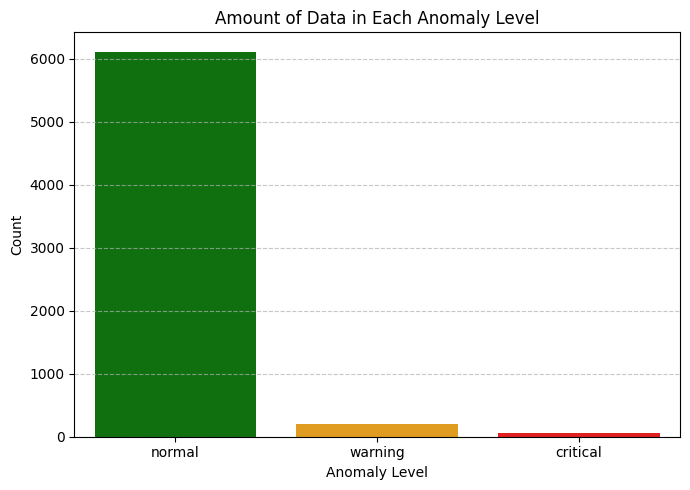

In [63]:
# --- 2. Anomaly Level Counts ---
plt.figure(figsize=(7, 5))
sns.countplot(data=df_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)
plt.title('Amount of Data in Each Anomaly Level')
plt.xlabel('Anomaly Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

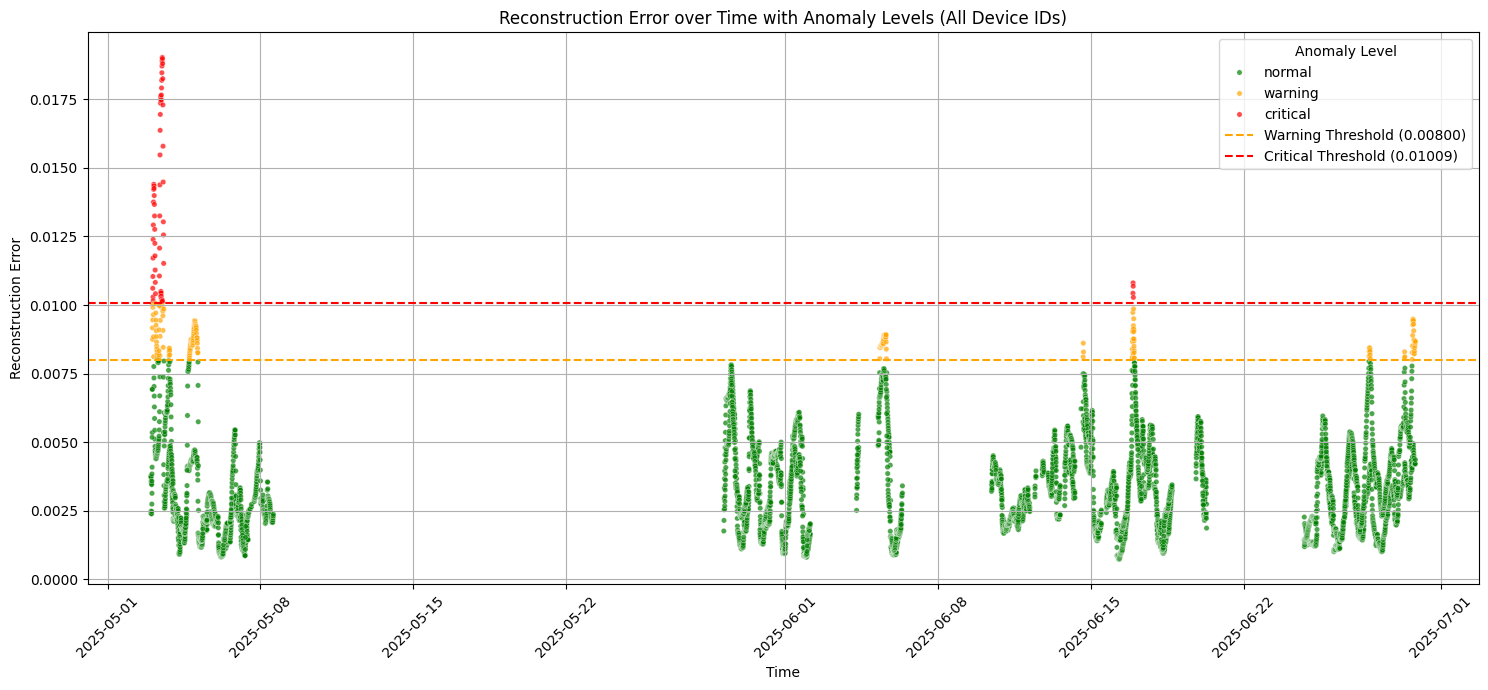

In [64]:
# --- 3. Reconstruction Error Over Time with Anomaly Levels (All Devices) ---
plt.figure(figsize=(15, 7))
sns.scatterplot(
    data=df_results, x='timestamp', y='reconstruction_error',
    hue='anomaly_level', palette=palette_anomaly, alpha=0.7, s=15,
    hue_order=['normal', 'warning', 'critical']
)
plt.axhline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axhline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Reconstruction Error over Time with Anomaly Levels (All Device IDs)')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.xticks(rotation=45)
plt.legend(title='Anomaly Level')
plt.tight_layout()
plt.grid(True)
plt.show()


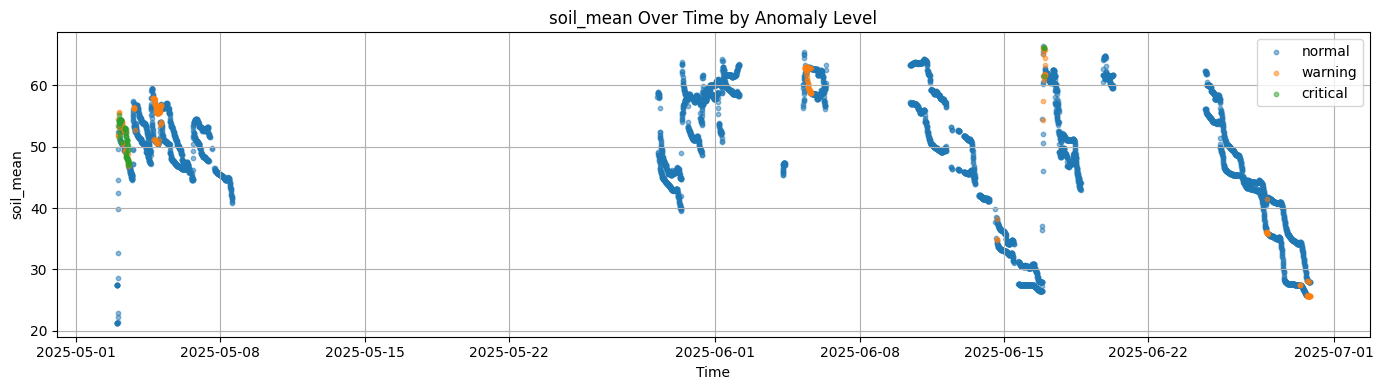

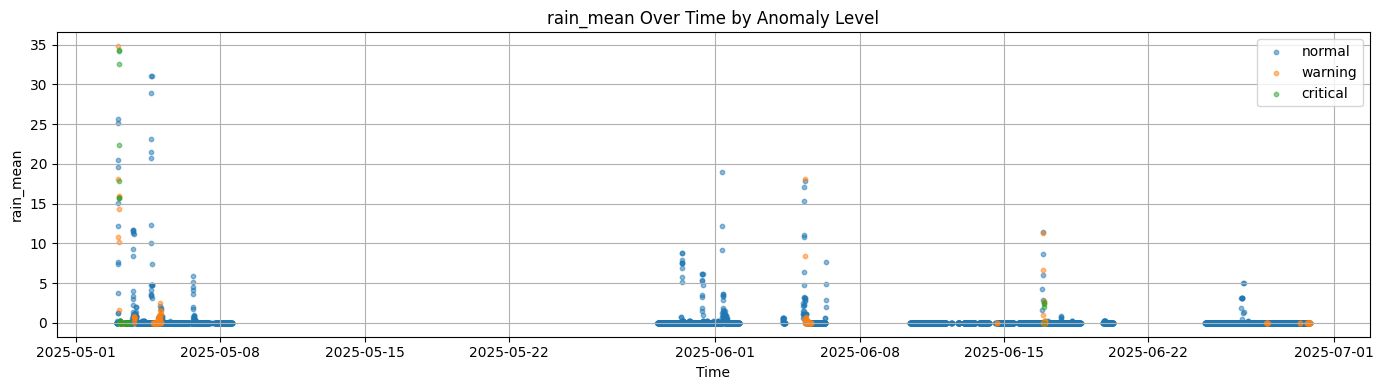

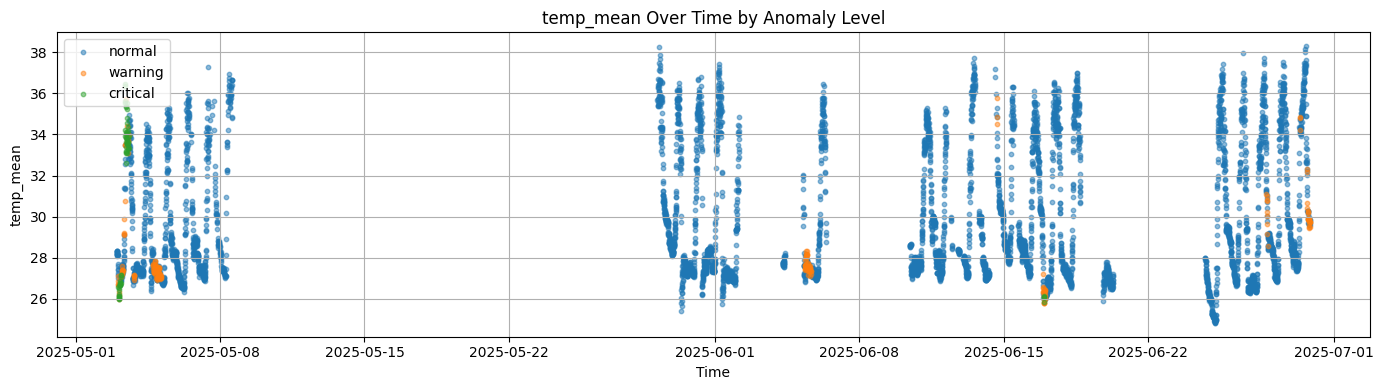

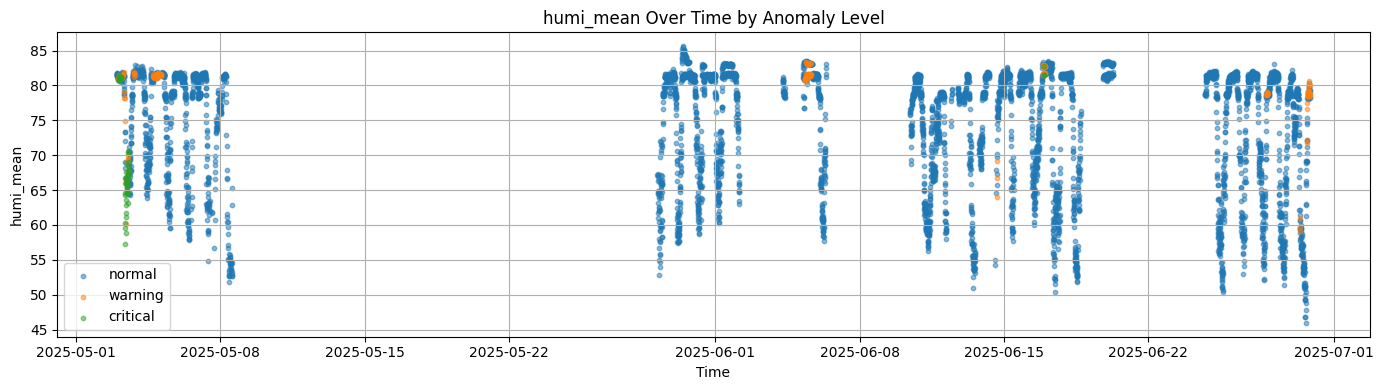

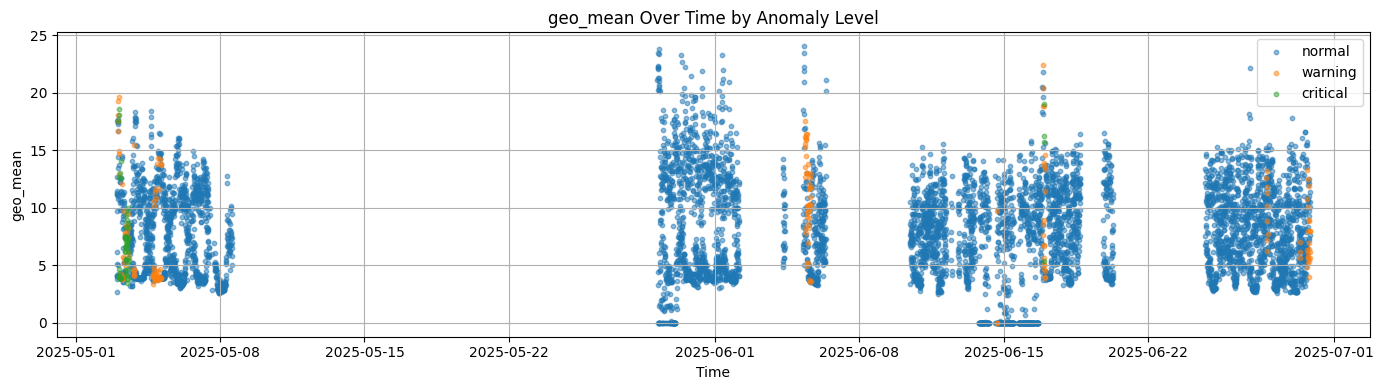

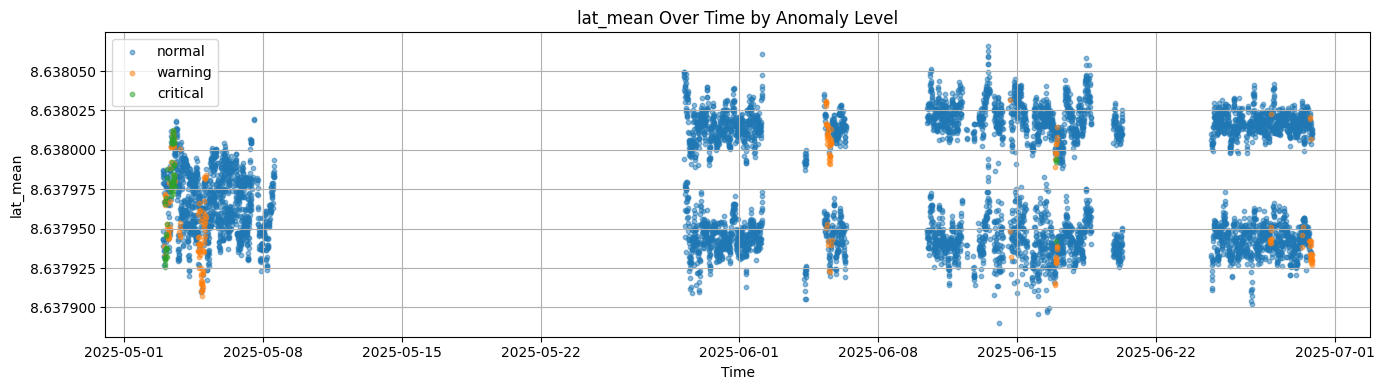

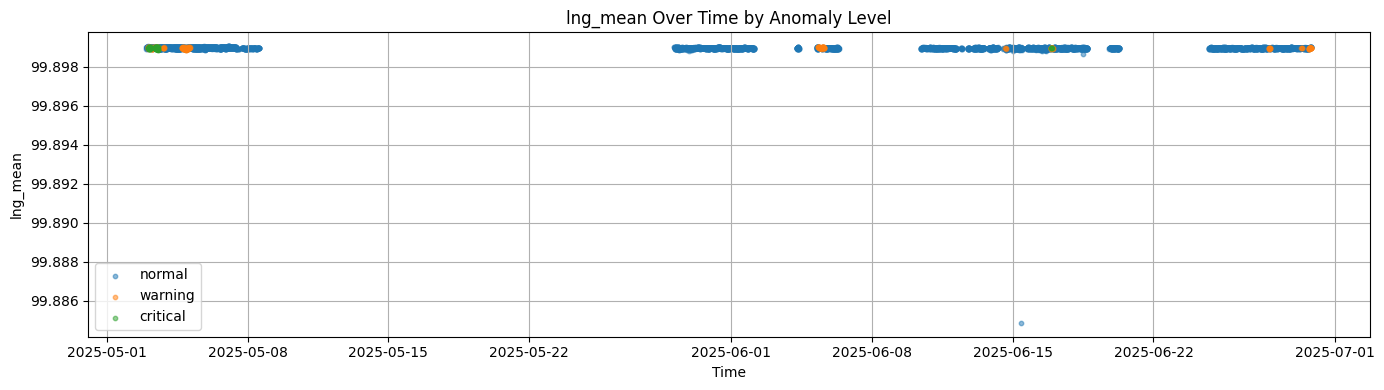

In [65]:
numerical_col_show = ['soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean', 'lat_mean', 'lng_mean']
#numerical_col
for feature in numerical_col_show:
    plt.figure(figsize=(14, 4))
    for level in ['normal', 'warning', 'critical']:
        subset = df_results[df_results['anomaly_level'] == level]
        plt.scatter(subset['timestamp'], df_original_features.loc[subset['original_df_index'], feature],
                    label=level, alpha=0.5, s=10)
    plt.title(f'{feature} Over Time by Anomaly Level')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

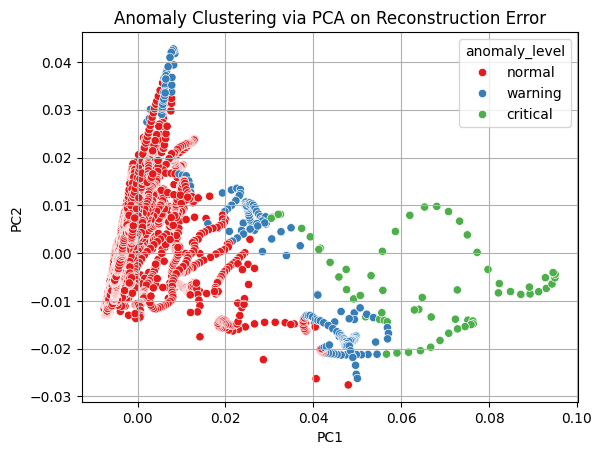

In [66]:
from sklearn.decomposition import PCA
import seaborn as sns

# สร้าง feature จาก reconstruction error
X_error = np.mean((X_seq_test - X_pred)**2, axis=1)  # shape: (num_samples, seq_len)

# ลดมิติด้วย PCA เพื่อ visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_error)

df_viz = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_viz['anomaly_level'] = df_results['anomaly_level']

# วาดกราฟ
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='anomaly_level', palette='Set1')
plt.title("Anomaly Clustering via PCA on Reconstruction Error")
plt.grid(True)
plt.show()



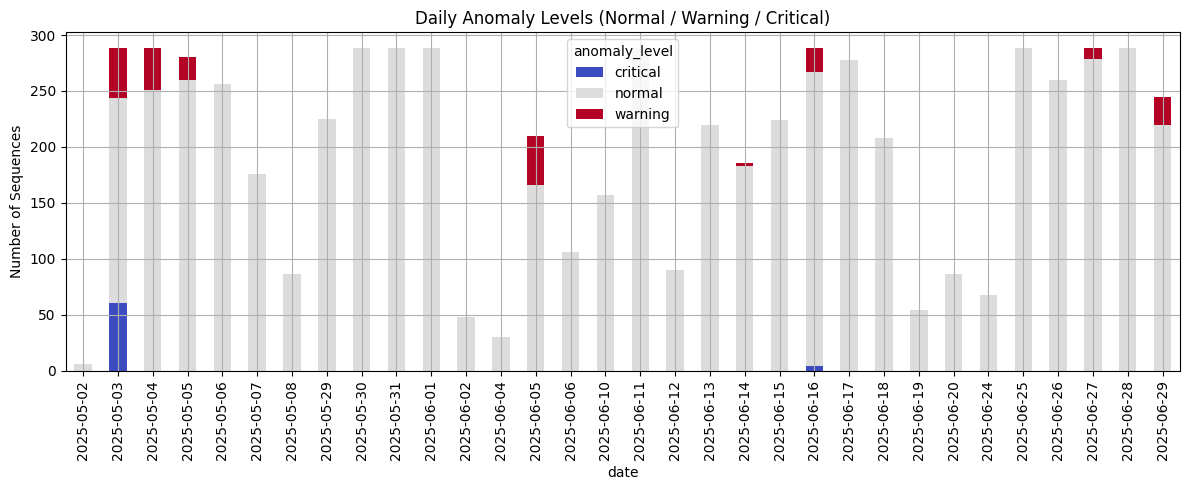

In [67]:
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date
alerts_per_day = df_results.groupby(['date', 'anomaly_level']).size().unstack(fill_value=0)

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12, 5), colormap='coolwarm')
plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.ylabel("Number of Sequences")
plt.grid(True)
plt.tight_layout()
plt.show()


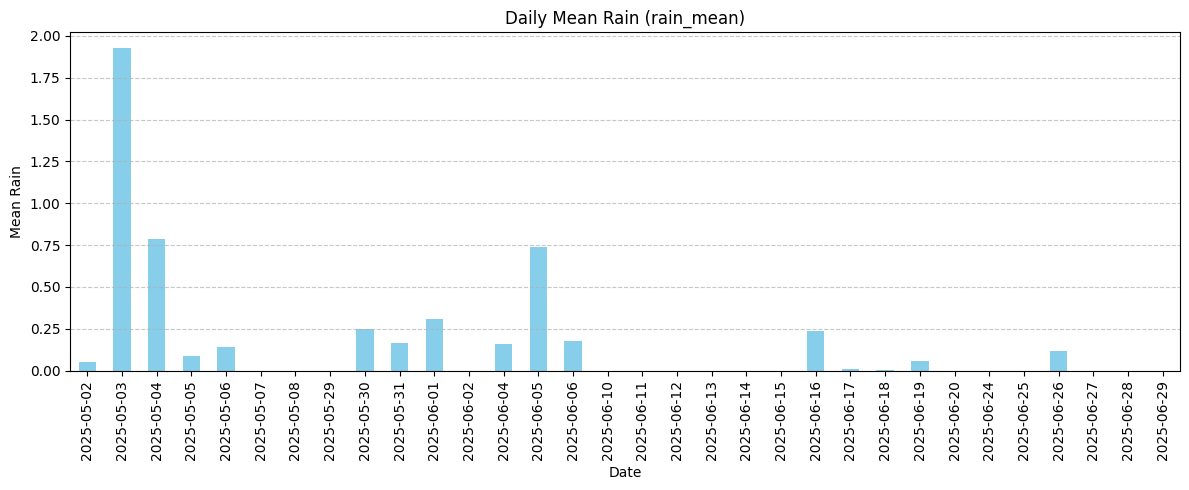

In [68]:
# สร้าง daily mean ของ rain_mean
df_results = df_results.copy()
df_results['rain_mean'] = df_results['original_df_index'].map(df_test['rain_mean'])
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# คำนวณค่าเฉลี่ย rain_mean ต่อวัน
daily_rain = df_results.groupby('date')['rain_mean'].mean()

# วาด bar plot
plt.figure(figsize=(12, 5))
daily_rain.plot(kind='bar', color='skyblue')
plt.title("Daily Mean Rain (rain_mean)")
plt.ylabel("Mean Rain")
plt.xlabel("Date")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


จำนวน critical anomalies ในวันที่ [datetime.date(2025, 6, 16), datetime.date(2025, 6, 17)]: 21


,devID,timestamp,reconstruction_error,original_df_index
2076,101,2025-06-16 21:20:00,0.008091,4426
2077,101,2025-06-16 21:30:00,0.008394,4428
2078,101,2025-06-16 21:40:00,0.008665,4430
2079,101,2025-06-16 21:50:00,0.009035,4432
2080,101,2025-06-16 22:00:00,0.009729,4434
5327,102,2025-06-16 22:10:00,0.008245,4437
5328,102,2025-06-16 22:20:00,0.008761,4439
5329,102,2025-06-16 22:30:00,0.009079,4441
5330,102,2025-06-16 22:40:00,0.009250,4442
2085,101,2025-06-16 22:50:00,0.009864,4445


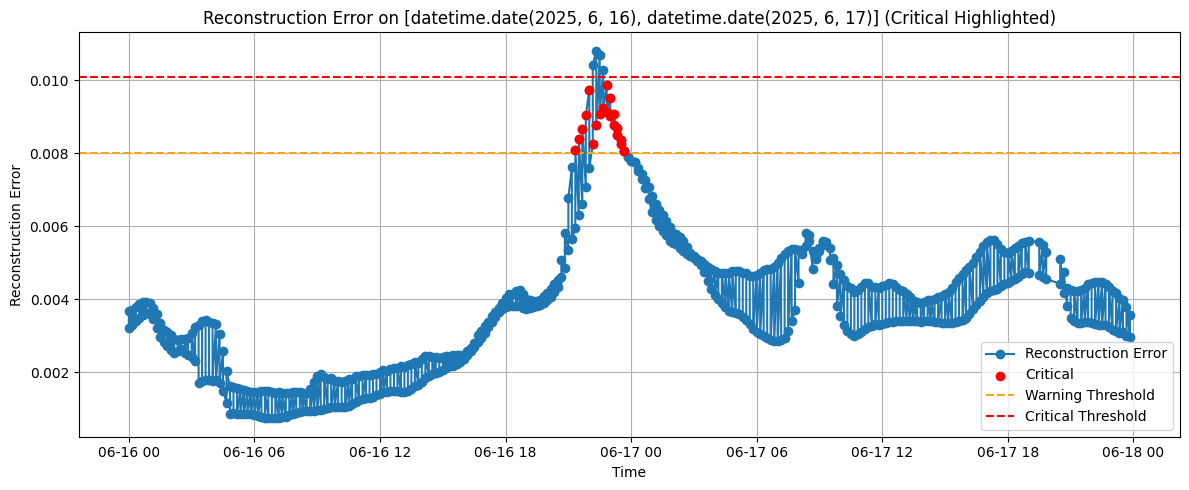

ค่า features ของ sequence critical ในวันนั้น:


,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,lat_mean,lng_mean
4426,2025-06-16 21:20:00,101,65.020001,6.663690,27.204756,81.677054,18.894387,8.637994,99.898957
4428,2025-06-16 21:30:00,101,65.554546,8.610600,26.861826,81.612146,20.414235,8.637999,99.898953
4430,2025-06-16 21:40:00,101,66.341464,11.400883,26.657819,81.632191,21.773784,8.637997,99.898947
4432,2025-06-16 21:50:00,101,66.034782,11.315700,26.510534,81.547894,22.431428,8.637999,99.898949
4434,2025-06-16 22:00:00,101,66.099999,0.989542,26.313134,81.534970,20.428568,8.637989,99.898946
4437,2025-06-16 22:10:00,102,61.320408,0.000000,25.800717,82.758112,6.647530,8.637929,99.898934
4439,2025-06-16 22:20:00,102,60.858140,0.000000,25.796565,82.855283,5.091562,8.637929,99.898929
4441,2025-06-16 22:30:00,102,61.407693,0.000000,25.802331,82.789806,5.062968,8.637932,99.898940
4442,2025-06-16 22:40:00,102,61.440425,0.000000,25.852345,82.755726,5.411645,8.637942,99.898937
4445,2025-06-16 22:50:00,101,65.937501,2.561167,26.335053,81.667095,8.935831,8.637997,99.898929


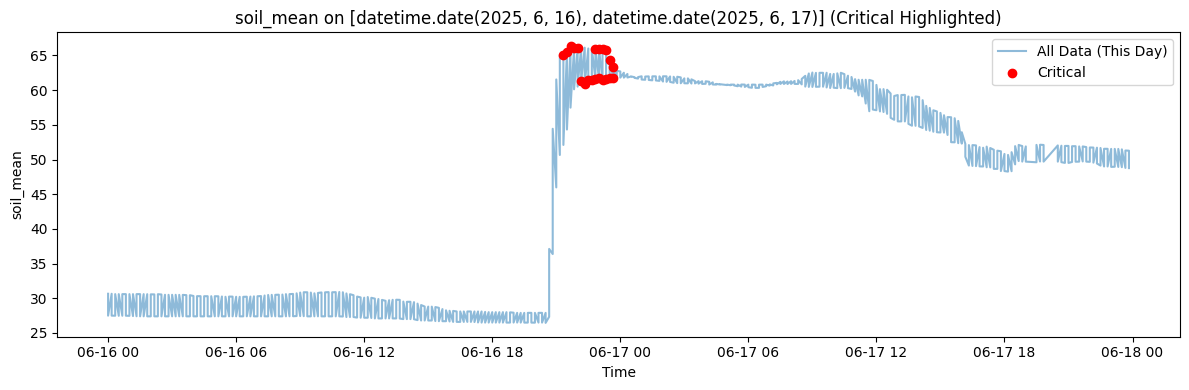

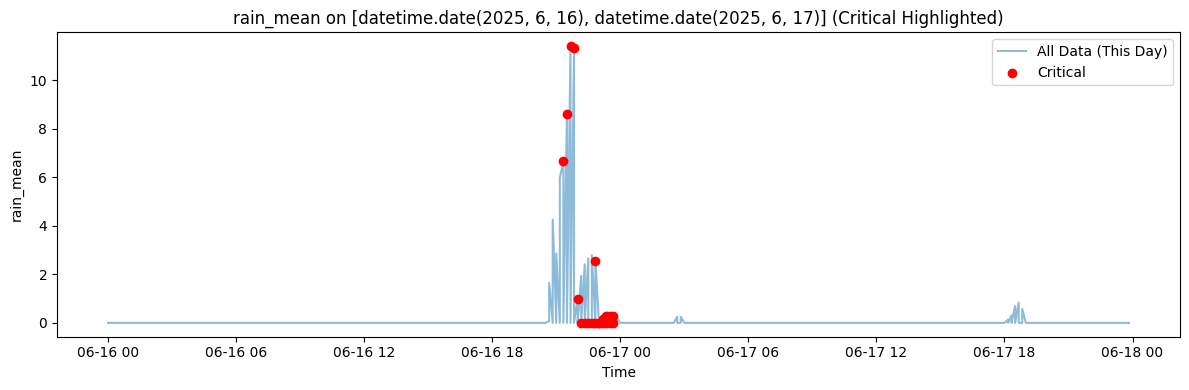

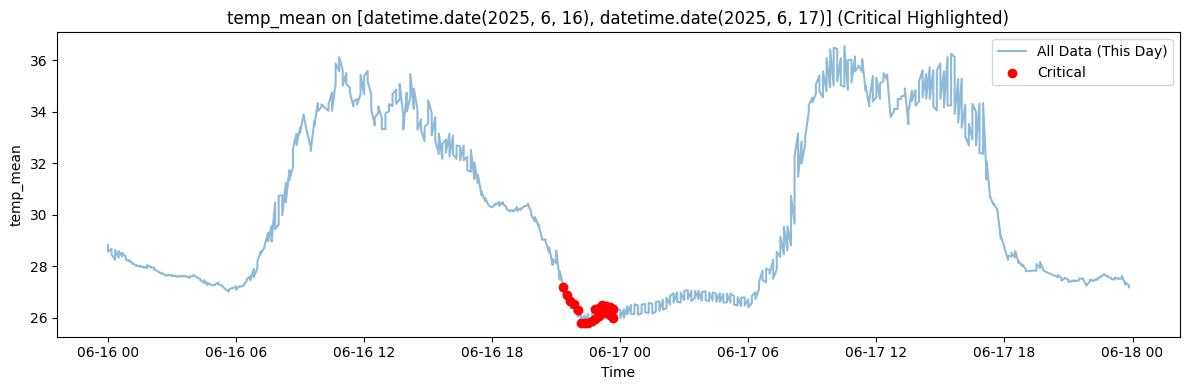

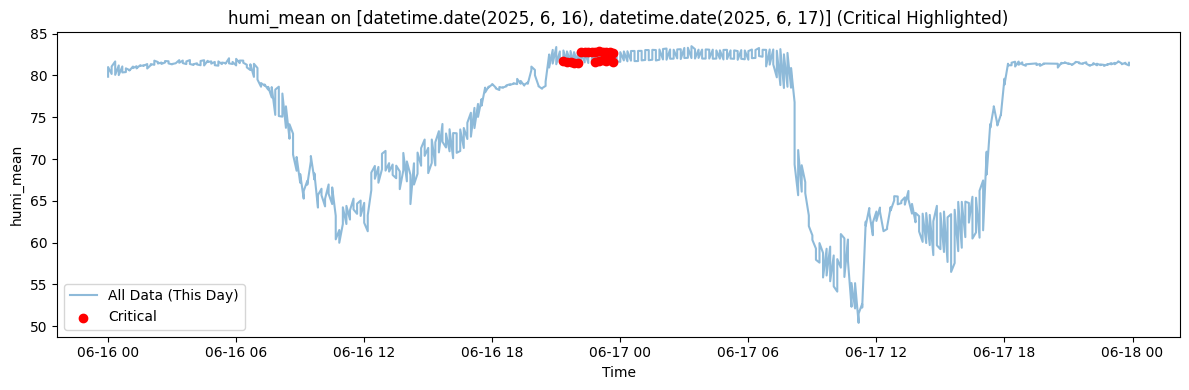

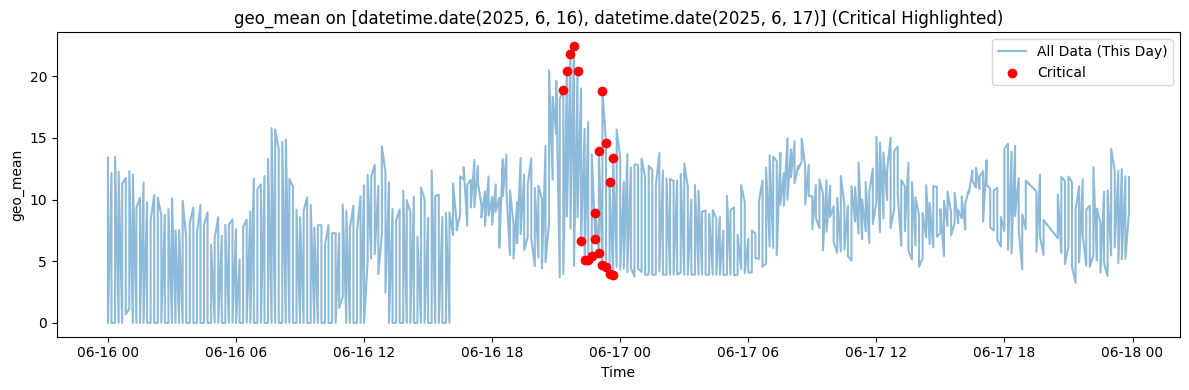

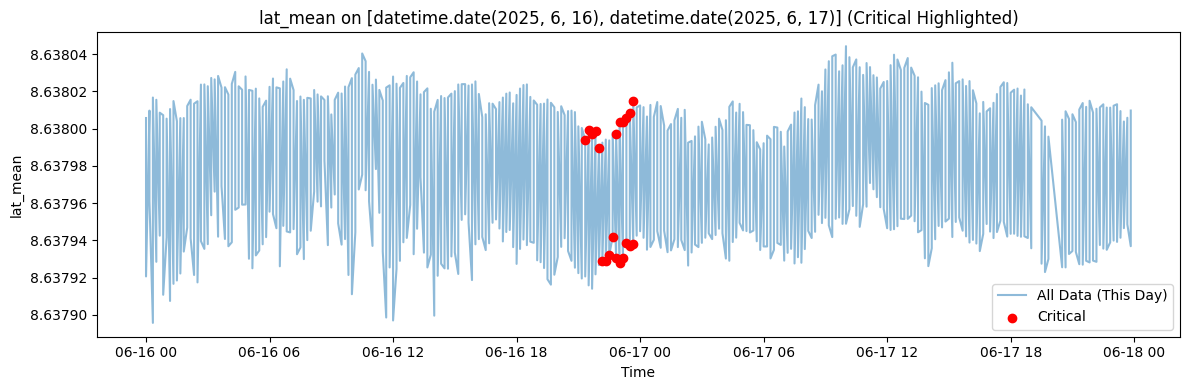

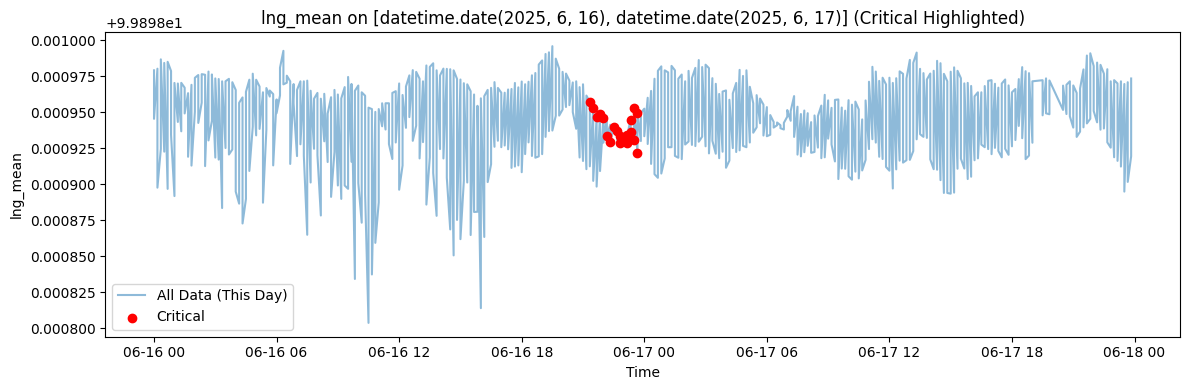

In [75]:
from IPython.display import display

# เลือกเฉพาะวันที่ 15 ถึง 18 มิ.ย. 2025
dates_of_interest = [pd.to_datetime(f'2025-06-{day:02d}').date() for day in range(16, 18)]

# กรองข้อมูลที่ anomaly_level เป็น critical และอยู่ในวันที่ที่สนใจ
critical_on_date = df_results[
    (df_results['timestamp'].dt.date.isin(dates_of_interest)) &
    (df_results['anomaly_level'] == 'warning')  # เปลี่ยนเป็น 'critical' ถ้าต้องการเฉพาะ critical
]

print(f"จำนวน critical anomalies ในวันที่ {dates_of_interest}: {len(critical_on_date)}")
display(critical_on_date[['devID', 'timestamp', 'reconstruction_error', 'original_df_index']])

# ถ้ามี critical anomalies ให้ plot กราฟ
if not critical_on_date.empty:
    plt.figure(figsize=(12, 5))
    mask_date = df_results['timestamp'].dt.date.isin(dates_of_interest)

    plt.plot(
        df_results.loc[mask_date, 'timestamp'],
        df_results.loc[mask_date, 'reconstruction_error'],
        label='Reconstruction Error', marker='o'
    )
    plt.scatter(
        critical_on_date['timestamp'],
        critical_on_date['reconstruction_error'],
        color='red', label='Critical', zorder=10
    )
    plt.axhline(y=threshold_warning, color='orange', linestyle='--', label='Warning Threshold')
    plt.axhline(y=threshold_critical, color='red', linestyle='--', label='Critical Threshold')
    plt.title(f'Reconstruction Error on {dates_of_interest} (Critical Highlighted)')
    plt.xlabel('Time')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("ไม่พบ critical anomalies ในวันที่นี้")

idxs = critical_on_date['original_df_index'].values
features_to_show = numerical_col_show  # ตัวแปรนี้คุณต้องกำหนดไว้ เช่น ['soil_mean', 'rain_mean', ...]

feature_df = df_test.loc[idxs, ['timestamp', 'devID'] + features_to_show]
print("ค่า features ของ sequence critical ในวันนั้น:")
display(feature_df)
# วาดกราฟแสดงค่าของแต่ละ feature
for feature in features_to_show:
    plt.figure(figsize=(12, 4))
    mask_date = df_test['timestamp'].dt.date.isin(dates_of_interest)
    
    plt.plot(
        df_test.loc[mask_date, 'timestamp'],
        df_test.loc[mask_date, feature],
        label='All Data (This Day)', alpha=0.5
    )
    plt.scatter(
        feature_df['timestamp'],
        feature_df[feature],
        color='red', label='Critical', zorder=10
    )
    plt.title(f"{feature} on {dates_of_interest} (Critical Highlighted)")
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.tight_layout()
    plt.show()